# Whisper Transcribe
OpenAI Whisper test and evaluation for German language audio files.

DUT:
* AMD Ryzen 7 3800XT (8-Core 3.90 GHz)
* Nvidia RTX 3070 (8GB)
* 64GB RAM

## Execution
For the different available models, perform transcription and match the output to the manual transcript.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import torch
import whisper
from datetime import datetime
from difflib import SequenceMatcher

In [7]:
# init SequenceMatcher
similar = lambda a, b: SequenceMatcher(None, a, b).ratio()

audio_file = os.path.join(os.getcwd(), '20221007_stochastik_zufall.m4a')  # path to file
audio_length = 22  # seconds
manual_transcript = """Zufall ist, in unserem Kontext, nicht ein im Hintergrund unseres Daseins wirkendes Prinzip, das unser Leben zu beeinträchtigen in der Lage ist, sondern das Wort dient zur Charakterisierung einer Situation, in der wir auf Grund fehlender Informationen den Ausgang eines Experiments nicht vorhersehen können."""
language_whisper = "German"
device = "cuda" if torch.cuda.is_available() else "cpu"

results_df = pd.DataFrame({
    "Model": ["tiny", "base", "small", "medium", "large"],
    "Language": "German",
    "Manual Transcript": manual_transcript,
    "Audio Length": audio_length,
    "Whisper Transcript": str(),
    "Transcription Duration": np.nan,
    "t-t Factor": np.nan,
    "Match": np.nan
})

# print(results_df.head())

In [8]:
idx = 0

for w_model in results_df.Model:
    # load model
    model = whisper.load_model(w_model, device=device)  # select model: tiny, base, small, medium, large
    
    timestamp_start = datetime.now()
    result = model.transcribe(audio_file, language=results_df.Language)
    timestamp_end = datetime.now()

    results_df.iloc[idx, 5] = (timestamp_end - timestamp_start).seconds
    results_df.iloc[idx, 6] = round(duration/audio_length, 2)
    results_df.iloc[idx, 7] = round(similar(manual_transcript, result['text']) * 100, 2)
    
    idx += 1

# print(f"[+] Task executed in {duration}s (factor 1:{factor}), matching: {match}%")
# print("[i] Result:\n", result["text"])
print(results_df)

FileNotFoundError: [WinError 2] Das System kann die angegebene Datei nicht finden

## Evaluation

Evaluation and visualization of the outcome.
All values are to be understood as averages of 100 trials.

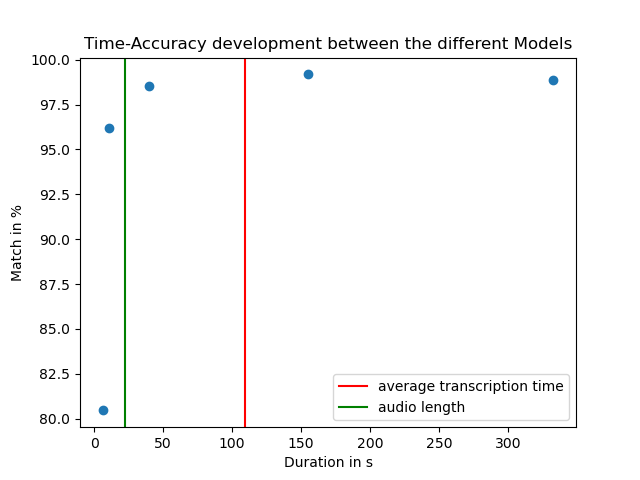

In [9]:
transcription_time_avg = np.mean(results_df["Transcription Duration"])

# plt.bar(results_df["Model"], results_df["Transcription Duration"])

%matplotlib widget
plt.scatter(results_df["Transcription Duration"], results_df["Match"])
plt.axvline(transcription_time_avg, color="red", label="average transcription time")
plt.axvline(audio_length, color="green", label="audio length")
plt.legend(loc="lower right")
plt.xlabel("Duration in s")
plt.ylabel("Match in %")
plt.title("Time-Accuracy development between the different Models")
plt.show()

# Result

For my devices research has shown, that the small model offers the best time-match tradeoff with a time factor of only 1:1.64 and a accuracy of 98.5%. Interestingly, the large model performed worse than the medium one, although needing nearly twice as much time.